### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 6
### Due: Saturday, Mar 22nd at 11.59pm CT
---

This problem has to do with density estimation and clustering. 

1. Read in `hw6_data_1.npy`. The dataset should consist of $1000$ samples with $2$ features. Note that the last column are the labels, not another feature. Make a $2$-D scatter plot of the data colored by their labels. 


2. Start with kernel density estimation on the data set. First, perform a grid search $5$-fold cross-validation to find the best bandwidth, testing $30$ bandwidths between $0.1$ and $1.0$. What is this best bandwidth? Using this best bandwidth, plot the two-dimensional kernel density estimate of the distribution. 


3. Now try a nearest neighbors approach to estimating the density. Use the Bayesian nearest neighbors option. Plot the estimated distribution. What value of $k$ neighbors do you need to make the plot look similar to your KDE distribution?


4. Now fit a Gaussian mixture model. Compute the AIC and BIC for the number of GMM components between $1$ and $10$. Plot these AIC and BIC values as a function of number of components. What is the optimal number according to the BIC? Fit the data set with this optimal number of GMM components, and create a new plot that shows the data set, the GMM component mean locations, and the $2$-sigma GMM component ellipses. *(Use the code below to help with plotting the ellipses.)*

In [1]:
# Kludge to fix the bug with draw_ellipse in astroML
from matplotlib.patches import Ellipse

def draw_ellipse(mu, C, scales=[1, 2, 3], ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    # find principal components and rotation angle of ellipse
    sigma_x2 = C[0, 0]
    sigma_y2 = C[1, 1]
    sigma_xy = C[0, 1]

    alpha = 0.5 * np.arctan2(2 * sigma_xy,
                          (sigma_x2 - sigma_y2))
    tmp1 = 0.5 * (sigma_x2 + sigma_y2)
    tmp2 = np.sqrt(0.25 * (sigma_x2 - sigma_y2) ** 2 + sigma_xy ** 2)

    sigma1 = np.sqrt(tmp1 + tmp2)
    sigma2 = np.sqrt(tmp1 - tmp2)

    for scale in scales:
        ax.add_patch(Ellipse(xy=(mu[0], mu[1]),
                          width=2 * scale * sigma1, height=2 * scale * sigma2,
                          angle=alpha * 180. / np.pi,
                          **kwargs))

5. Now try Kmeans clustering with $5$ clusters. 
    - Use the `StandardScalar` to scale the data.
    - Fit the Kmeans model.
    - Find the cluster centers, and then inverse transform thse cluster centers back to the original unscaled coordinates.
    - Predict the labels for the scaled data.
    - Finally, make a two-panel side by side plot showing (a) the original data colored by its labels, then (b) the data colored by the Kmeans predicted labels, with cluster centers superposed.

### Solution

Part 1

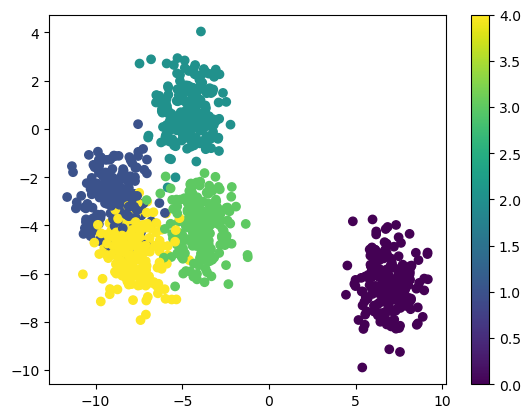

In [2]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

#load in data
hw_data = np.load("../../../homeworks/hw_data/hw6_data_1.npy")
feature1 = hw_data[:,0]
feature2 = hw_data[:,1]
labels = hw_data[:,2]

plt.scatter(feature1,feature2,c=labels)
plt.colorbar()

Part 2

the optimal bandwidth is: 0.4724137931034482


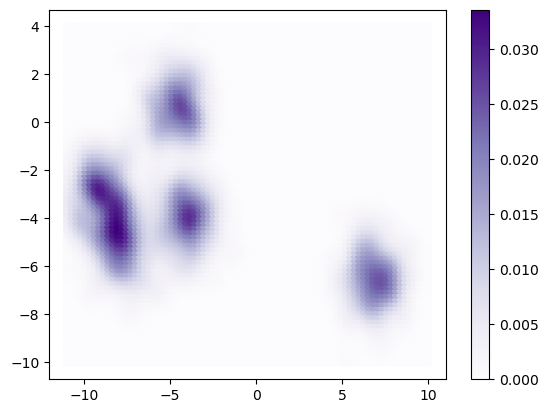

In [3]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

X = np.column_stack([feature1,feature2]) #make into 2D array
bwrange = np.linspace(0.1, 1.0, 30) # Test 30 bandwidths from 0.1 to 1.0
K = 5 # Do 5-fold cross validation
grid = GridSearchCV(KernelDensity(), {'bandwidth': bwrange}, cv=K) # Try each bandwidth with K-folds
grid.fit(X) #Fit the histogram data that we started the lecture with.
h_opt = grid.best_params_['bandwidth']
print('the optimal bandwidth is:', h_opt)


kde = KernelDensity(kernel='gaussian', bandwidth=h_opt)
kde.fit(X) #fit the model to the data

u = np.linspace(-11,10,80)
v = np.linspace(-10,4,80) 
Xgrid = np.vstack(list(map(np.ravel, np.meshgrid(u, v)))).T
dens = np.exp(kde.score_samples(Xgrid)) #evaluate the model on the grid
plt.scatter(Xgrid[:,0], Xgrid[:,1], c=dens, 
            cmap="Purples", edgecolor="None")
plt.colorbar()

Part 3

about 100 neighbors make this plot look like the 2D KDE


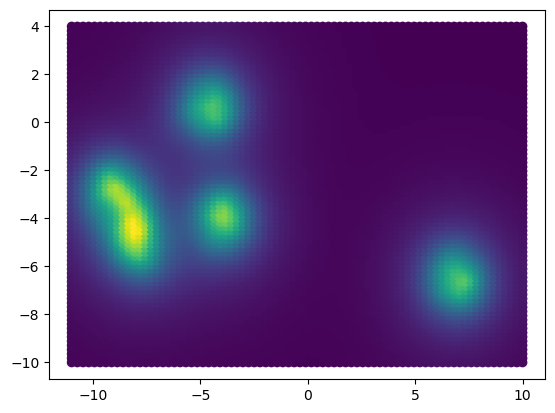

In [4]:
from astroML.density_estimation import KNeighborsDensity
k = 100 #Number of neighbors

Xgrid = np.vstack(list(map(np.ravel, np.meshgrid(u, v)))).T #transpose for the X-grid

# Compute density with Bayesian nearest neighbors
nbrs = KNeighborsDensity('bayesian', n_neighbors=k)
nbrs.fit(X)
dens_nbrs = nbrs.eval(Xgrid)


plt.scatter(Xgrid[:,0], Xgrid[:,1],c=dens_nbrs, 
         zorder=2, label="Nearest Neighbors (k=%i)" % k)

print('about 100 neighbors make this plot look like the 2D KDE')

Part 4

optimal number of components according to the BIC is 4


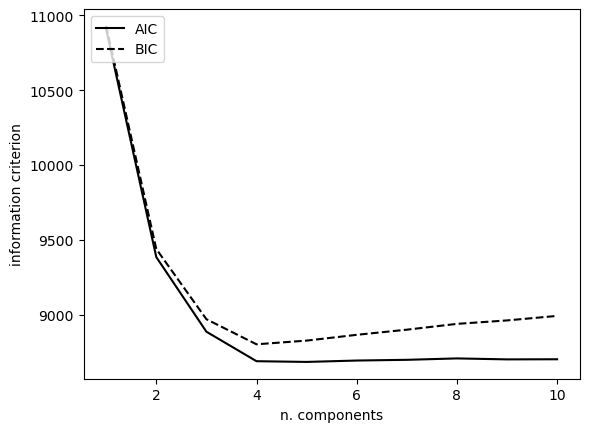

In [5]:
from sklearn.mixture import GaussianMixture

N = np.arange(1, 11) #number of components
models = [None for i in range(len(N))]

for i in range(len(N)):
    models[i] = GaussianMixture(N[i]).fit(X)

# compute the AIC and the BIC
AIC = [m.aic(X) for m in models]
BIC = [m.bic(X) for m in models]


plt.plot(N, AIC, '-k', label='AIC')
plt.plot(N, BIC, '--k', label='BIC')
plt.xlabel('n. components')
plt.ylabel('information criterion')
plt.legend(loc=2)

print('optimal number of components according to the BIC is 4')

In [6]:
gmm = GaussianMixture(4) #4, the optimal number of components
gmm.fit(X)
means = gmm.means_ #find means
cov = gmm.covariances_ #find covariances

from matplotlib.patches import Ellipse

def draw_ellipse(mu, C, scales=[1, 2, 3], ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    # find principal components and rotation angle of ellipse
    sigma_x2 = C[0, 0]
    sigma_y2 = C[1, 1]
    sigma_xy = C[0, 1]

    alpha = 0.5 * np.arctan2(2 * sigma_xy,
                          (sigma_x2 - sigma_y2))
    tmp1 = 0.5 * (sigma_x2 + sigma_y2)
    tmp2 = np.sqrt(0.25 * (sigma_x2 - sigma_y2) ** 2 + sigma_xy ** 2)

    sigma1 = np.sqrt(tmp1 + tmp2)
    sigma2 = np.sqrt(tmp1 - tmp2)

    for scale in scales:
        ax.add_patch(Ellipse(xy=(mu[0], mu[1]),
                          width=2 * scale * sigma1, height=2 * scale * sigma2,
                          angle=alpha * 180. / np.pi,
                          **kwargs))


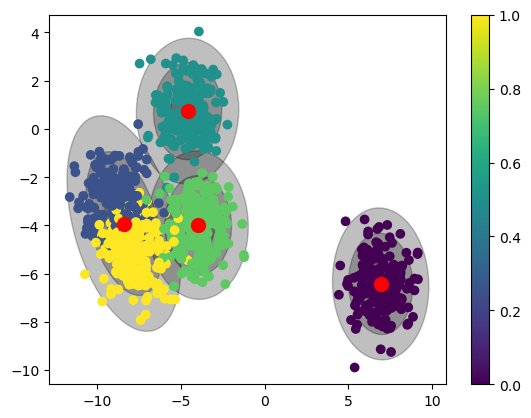

In [7]:
#loop over means
for i in range(len(means)):
    current_cov = cov[i]
    draw_ellipse(means[i],current_cov,alpha=0.25, color='black')

plt.scatter(feature1,feature2,c=labels)
plt.scatter(means[:,0], means[:,1],c='red',s=100)
plt.colorbar()


Part 5

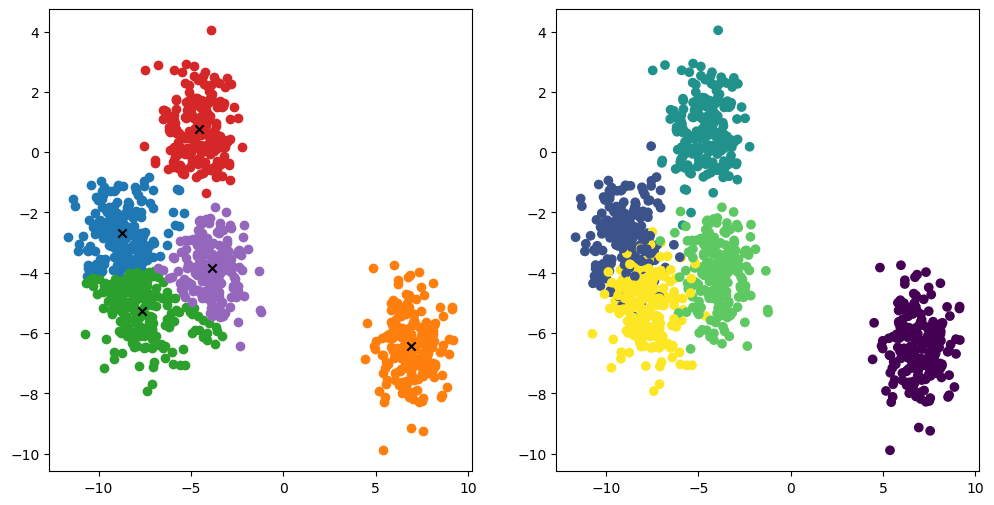

In [8]:
from sklearn import preprocessing
from sklearn.cluster import KMeans

n_clusters = 5 #number of clusters
scaler = preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(X) #scaled data

clf = KMeans(n_clusters)
clf.fit(X_scaled)
centers = clf.cluster_centers_ #location of the clusters
cluster_centers = scaler.inverse_transform(clf.cluster_centers_)
labels_pred = clf.predict(X_scaled) #labels for each of the points

# plot the data color-coded by cluster id
colors = ['C0','C1','C2','C3','C4']
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12, 6))

for ii in range(5):
    ax1.scatter(X[labels_pred==ii,0], X[labels_pred==ii,1], 
                color=colors[ii])
ax1.scatter(cluster_centers[:,0],cluster_centers[:,1],c='black',marker='x')
ax2.scatter(feature1,feature2,c=labels)